In [18]:
# notebook last tested with abtem version 1.0.0beta7

from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell

current version: 1.0.0beta8


# STEM simulation of MoS$_2$

We set up an atomic structure with ASE and make sure to repeat the structure to improve the Fourier space sampling for our diffraction patterns.

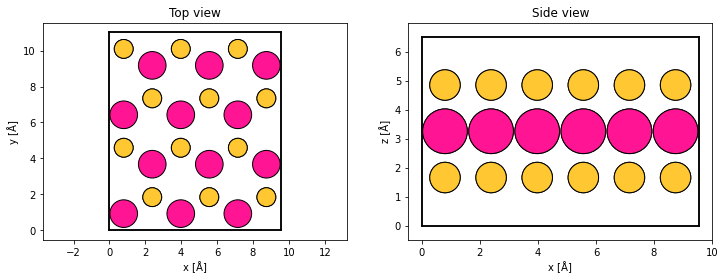

In [19]:
atoms = mx2(formula='MoS2', kind='2H', a=3.18, thickness=3.19, size=(1, 1, 1), vacuum=None)

repetitions = (3, 2, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.cell[2,2] = 6.5
atoms.center()

#atoms *= (1,1,5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [20]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([9.540000000000001, 11.01584313613806, 6.5])


We create and calculate the electrostatic potential.

In [33]:
potential = Potential(atoms, 
                      gpts=256,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

potential = potential.build()

In [34]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.037265625000000004, 0.043030637250539294)


We create a probe with a semi-angle cutoff of 20 mrad.

In [35]:
probe = Probe(energy=80e3, semiangle_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)

To run this simulation using PRISM instead of the standard multislice algorithm, uncomment the cell below. 

Note that while PRISM may be up to 1000 times faster than multislice for large structures, the performance is fairly similar for small simulations.

In [36]:
# probe = SMatrix(energy=80e3, semiangle_cutoff=20, expansion_cutoff=20, rolloff=0.1, defocus=40, Cs=3e5, focal_spread=20)

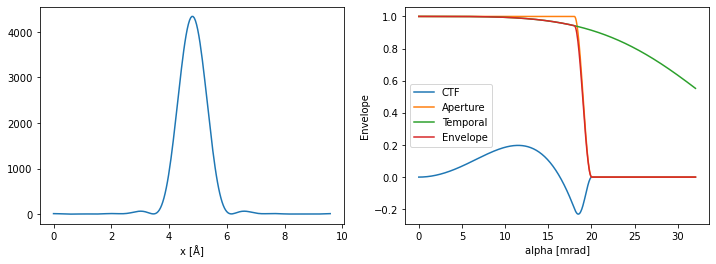

In [37]:
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

probe.profile().show(ax=ax1);

probe.ctf.show(ax=ax2);

We create a `FlexibleAnnularDetector` detector which will allow to choose the integration limits after the multislice simulation.

In [38]:
detector = FlexibleAnnularDetector()

We scan over one periodic unit of the potential at slightly better than the Nyquist frequency of the probe contrast transfer function.

In [39]:
end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9)

measurements = probe.scan(gridscan, [detector], potential)

The output from the simulation is a `Measurement` object. This wraps a numpy array with calibrations descibing each axis. 

In our case, the first two dimensions of the numpy array scan dimenstions and the last dimension are the bins of the detector.

In [40]:
measurements[detector].array.shape

(7, 12, 323)

We reduce the measurement to an image by integrating over the detector dimension.

In [41]:
measurements[detector].integrate(0, 20).array.shape

(7, 12)

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x26ac68c1c70>)

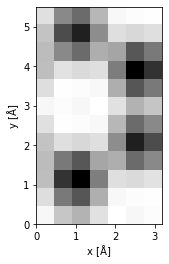

In [42]:
measurements[detector].integrate(0, 20).show()

We can get a better view of the simulation output by tiling and interpolation the output.

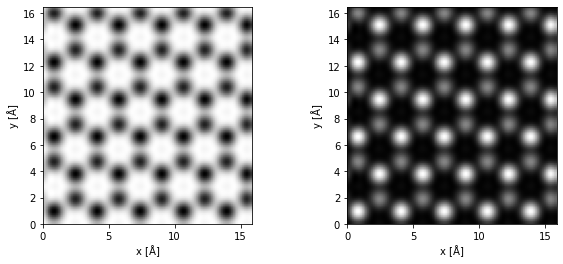

In [44]:
bright_measurement = measurements[detector].integrate(0, 20)
haadf_measurement = measurements[detector].integrate(50, 150)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

bright_measurement.tile((5,3)).interpolate(.05).show(ax=ax1)

haadf_measurement.tile((5,3)).interpolate(.05).show(ax=ax2);